## Imports

In [1]:
import gym
import numpy      as np
import torch      as t
import torch.nn   as nn
import matplotlib.pyplot as plt

from collections    import OrderedDict
from tqdm           import tnrange
from graphviz       import Digraph
from torch.autograd import Variable
from torchviz       import make_dot

In [2]:
device = t.device('cpu')
seed   = 42
t.manual_seed(seed)
np.random.seed(seed)

## Helper functions

In [12]:
# List of Cumulative Sum, with each term progressively discounted
def discount_cumsum(rewards, discount):
    result = []
    for i in range(len(rewards)):
        d_cummulative_sum = sum([x * discount**(idx) for idx, x in enumerate(rewards[i:])])
        result.append(d_cummulative_sum)
    return result

## Buffer

In [1]:
class PPOBuffer:
    
    def __init__(self, obs_dim, gamma=0.99, lam=0.97):
        '''
        PPOBuffer holds state, action, rewards tuples.
        Args:
        obs_dim (int)   - the input dimension
        gamma   (float) - controls the learning update. Defaults to 0.99
        lam     (float) = controls something else... Defaults to 0.97
        '''
        
        self.obs_dim   = obs_dim
        self.gamma     = gamma
        self.lam       = lam
        
        self.reset()
    
    def store(self, obs, act, rew, val, logp):
        '''
        Stores lists of observations, actions, rewards, values and logP's.
        lists must all have the same element count.
        Args:
        obs  list[float] - list of state observations in 2dim (e.g. [[1,2,3]])
        act  list[float] - list of actions
        rew  list[float] - list of rewards
        val  list[float] - list of values (advantage)
        logp list[float] - list of LogProbs (advantage)
        '''
        
        self.obs_buf  = np.append(self.obs_buf,  obs, axis=0)
        self.act_buf  = np.append(self.act_buf,  act)
        self.rew_buf  = np.append(self.rew_buf,  rew)
        self.val_buf  = np.append(self.val_buf,  val)
        self.logp_buf = np.append(self.logp_buf, logp)

        self.idx_e += 1
    
    def finish_path(self, last_val=0):
        '''
        This method is called at the end of a trjectory in order to calculate the trajectory's
        advantage and returns (a discounted cumulative sum of the rewards in the trajectory).
        
        The advantage is calculated using the General Advantage Estimation method, which is a
        hybrid of a monte-carlo and TD update (the lambda hyperparam shifts how much weight one
        effect has over the other: a lambda=1 is 100% Monte Carlo, lambda=0 is 1-step TD learning).
        
        The GAE method is better explained here: https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html#combining-td-and-mc-learning
        '''
        rews_slice = np.append(self.rew_buf[self.idx_s : self.idx_e], last_val)
        vals_slice = np.append(self.val_buf[self.idx_s : self.idx_e], last_val)

        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews_slice[:-1] + self.gamma * vals_slice[1:] - vals_slice[:-1]  # TD
        advs   = discount_cumsum(deltas, self.gamma * self.lam) # Monte Carlo
        self.adv_buf = np.append(self.adv_buf, advs)

        # the next line computes rewards-to-go, to be targets for the value function
        self.ret_buf = np.append(self.ret_buf, discount_cumsum(rews_slice, self.gamma)[:-1])

        self.idx_s = self.idx_e
        
    def get(self):
        '''
        Returns all of the observations, actions, advantages, returns & logprobs
        in a list of [[obs], [acts], [advs], [rets], [logps]]
        '''
        return [self.obs_buf, self.act_buf, self.adv_buf, self.ret_buf, self.logp_buf]
    
    def reset(self):
        '''
        Returns PPO Buffer to its original, empty state
        '''
        
        self.obs_buf  = np.empty((0, self.obs_dim))
        self.act_buf  = np.array([])
        self.rew_buf  = np.array([])
        self.val_buf  = np.array([])
        self.adv_buf  = np.array([])
        self.ret_buf  = np.array([])
        self.logp_buf = np.array([])
        self.idx_e    = 0
        self.idx_s    = 0

## Model

In [27]:
class PPOModel(nn.Module):
    
    def __init__(self, obs_dim, act_dim, hidden_size=64, pi_lr=3e-4, v_lr=1e-3, 
                 clip_ratio=.2, max_kl=0.01, train_pi_iters=80, train_v_iters=80,
                 categorical=True, buffer_kwargs=None):
        '''
        The PPO Agent. Class builds Actor Critic networks. Can act in both
        discrete and continuous environments.
        Args:
        obs_dim         (int) - the number of inputs flattened.
        act_dim         (int) - the number of outputs.
        hidden_size     (int) - the size of each hidden layer (all of equal size). Defaults to 64.
        pi_lr         (float) - actor network learning rate. Defaults to 3e-4.
        v_lr          (float) - critic network learning rate. Defaults to 1e-3.
        clip_ratio    (float) - amount to clip updates by. Defaults to 0.2.
        max_kl        (float) - the max amount of divergence in policy update. Halts learning beyond this
                                point. Defaults to 0.01.
        train_pi_iters  (int) - amount of actor network training iterations. Defaults to 80.
        train_v_iters   (int) - amount of critic network training iterations. Defaults to 80.
        categorical (boolean) - whether output should be discrete. False for continuous. Defaults to True.
        buffer_kwargs  (dict) - Args to be fed to the PPO_Buffer class.
        '''
        
        super(PPOModel, self).__init__()
        
        # env
        self.obs_dim     = obs_dim
        self.act_dim     = act_dim
        self.categorical = categorical
        
        if categorical:
            self.act = self.act_categorical
        else:
            self.log_std = nn.Parameter(-0.5 * t.ones(act_dim, dtype=t.float32))
            self.act     = self.act_gaussian
        
        # params
        self.max_kl         = max_kl
        self.clip_ratio     = clip_ratio
        self.train_pi_iters = train_pi_iters
        self.train_v_iters  = train_v_iters
        
        # Build models
        self.actor  = self.build_actor_model(hidden_size)
        self.critic = self.build_critic_model(hidden_size)
        self.a_op   = t.optim.Adam(self.actor.parameters(),  lr = pi_lr)
        self.c_op   = t.optim.Adam(self.critic.parameters(), lr = v_lr)
        
        # buffer
        self.buf = PPOBuffer(obs_dim, **buffer_kwargs)
        
        # plot material
        self.kl_hist     = []
        self.p_loss_hist = []
        self.v_loss_hist = []
        self.move_hist   = []
    
    def build_actor_model(self, h_dim):
        '''
        Builds the Actor network. Layer and layer types are handcoded.
        Args:
        h_dim (int) - size of hidden layers. There are 2 hidden layers.
        '''
        
        model = nn.Sequential(OrderedDict({
            'a_input': nn.Linear(self.obs_dim, h_dim), # input
            'a_relu1': nn.ReLU(),
            'a_h1'   : nn.Linear(h_dim, h_dim),        # hidden 1
            'a_relu2': nn.ReLU(),
            'a_h2'   : nn.Linear(h_dim, h_dim),        # hidden 2
            'a_relu3': nn.ReLU(),
            'a_out'  : nn.Linear(h_dim, self.act_dim)  # output  
        }))
        
        return model
    
    def build_critic_model(self, h_dim):
        '''
        Builds the Critic network. Layer and layer types are handcoded.
        Args:
        h_dim (int) - size of hidden layers. There are 2 hidden layers.
        '''
        
        model = nn.Sequential(OrderedDict({
            'c_input': nn.Linear(self.obs_dim, h_dim), # input
            'c_tanh1': nn.Tanh(),
            'c_h1'   : nn.Linear(h_dim, h_dim),        # hidden 1
            'c_tanh2': nn.Tanh(),
            'c_h2'   : nn.Linear(h_dim, h_dim),        # hidden 2
            'c_tanh3': nn.Tanh(),
            'c_out'  : nn.Linear(h_dim, 1)             # output  
        }))
        
        return model
    
    def act_categorical(self, obs):
        '''
        Creates a categorical distribution based on the outputs (logits) of the Actor network.
        It then samples from this distribution and returns an action as well as log_prob of action.
        Args:
        obs tensor[float] - tensor of observations
        '''
        
        logits = self.actor(obs)
        policy = t.distributions.Categorical(logits=logits)
        pi     = policy.sample()
        logpi  = policy.log_prob(pi).squeeze()
        
        return pi, logpi
    
    def act_gaussian(self, obs):
        '''
        Creates a normal distribution based on the outputs of the Actor network.
        It then samples from this distribution and returns an action as well as log_prob of action.
        Args:
        obs tensor[float] - tensor of observations
        '''
        
        mu      = self.actor(obs)
        policy  = t.distributions.Normal(mu, self.log_std.exp())
        pi      = policy.sample()
        logpi   = policy.log_prob(pi).sum(dim=1)

        return pi, logpi
    
    def act(self, obs):
        
        raise NotImplementedError
    
    def val(self, obs):
        '''
        Gets the Critic network value for an observation
        Args:
        obs tensor[float] - tensor of observations
        '''
        
        logits = self.critic(obs)
        val    = t.squeeze(logits, dim=1)
        
        return val
    
    def update(self):
        
        # Retrieve memories from buffer
        buf = {k:t.from_numpy(v).float() for k,v in zip(['obs', 'acts', 'advs', 'rets', 'logps'], self.buf.get())}

        # Standardize Advantages
        buf['advs'] = (buf['advs'] - t.mean(buf['advs'])) / t.std(buf['advs'])
        
        # Reshape acts if continuous
        acts = buf['acts']
        if not self.categorical:
            acts = np.reshape(acts, (len(acts), 1))

        # For Plotting
        kls, p_ls, v_ls  = [], [], []
        
        # Policy gradient step
        for _ in range(self.train_pi_iters):

            if self.categorical:
                logits  = self.actor(buf['obs'])
                policy  = t.distributions.Categorical(logits=logits)
                logps   = policy.log_prob(acts).squeeze()
                
            else:
                mu      = self.actor(buf['obs'])
                policy  = t.distributions.Normal(mu, self.log_std.exp())
                logps   = policy.log_prob(acts).sum(dim=1)
                
            ratio       = (logps - buf['logps']).exp()
            clipped_adv = t.where(
                                buf['advs'] > 0, 
                                (1 + self.clip_ratio) * buf['advs'], 
                                (1 - self.clip_ratio) * buf['advs']
                            )
            pi_loss     = -(t.min(ratio * buf['advs'], clipped_adv)).mean()
            p_ls.append(pi_loss.item())
            
            # Early stopping
            kl = (buf['logps'] - logps).mean().item()
            kls.append(kl)
            if abs(kl) > self.max_kl:
                break

            self.a_op.zero_grad()
            pi_loss.backward()
            self.a_op.step()

        # Value function learning
        for _ in range(self.train_v_iters):
            v      = self.val(buf['obs'])
            v_loss = ((buf['rets'] - v) ** 2).mean()
            v_ls.append(v_loss.item())

            self.c_op.zero_grad()
            v_loss.backward()
            self.c_op.step()
        
        # Save results for plotting
        self.kl_hist.append(np.mean(kls))
        self.p_loss_hist.append(np.mean(p_ls))
        self.v_loss_hist.append(np.mean(v_ls))     

## Parameters

In [42]:
# Environment
envs    = ['CartPole-v0', 'Pendulum-v0', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pong-ram-v0']
env     = gym.make(envs[0])

# Params
epochs           = 10
games_per_epoch  = 100
steps_per_epoch  = games_per_epoch * 100
render           = True
create_new_model = True

# Discrete or Continuous action dim
categorical = True if isinstance(env.action_space, gym.spaces.Discrete) else False
act_dim     = env.action_space.n if categorical else env.action_space.shape[0]
obs_dim     = env.observation_space.shape[0]

model_kwargs = {
    'pi_lr'         : 3e-4,
    'v_lr'          : 1e-3,
    'clip_ratio'    : 0.2, #.1,.2,.3
    'max_kl'        : 0.03, #0.003 to 0.03
    'train_pi_iters': 80,
    'train_v_iters' : 80,
    'hidden_size'   : 64,
    'categorical'   : categorical
}
buffer_kwargs = {
    'lam'  : 0.97,
    'gamma': 0.99
}

print(f'Environment is {"Discrete" if categorical else "Continuous"} with {act_dim} actions')
try: print(env.unwrapped.get_action_meanings())
except: pass

Environment is Discrete with 2 actions


## Episodes

<IPython.core.display.Javascript object>


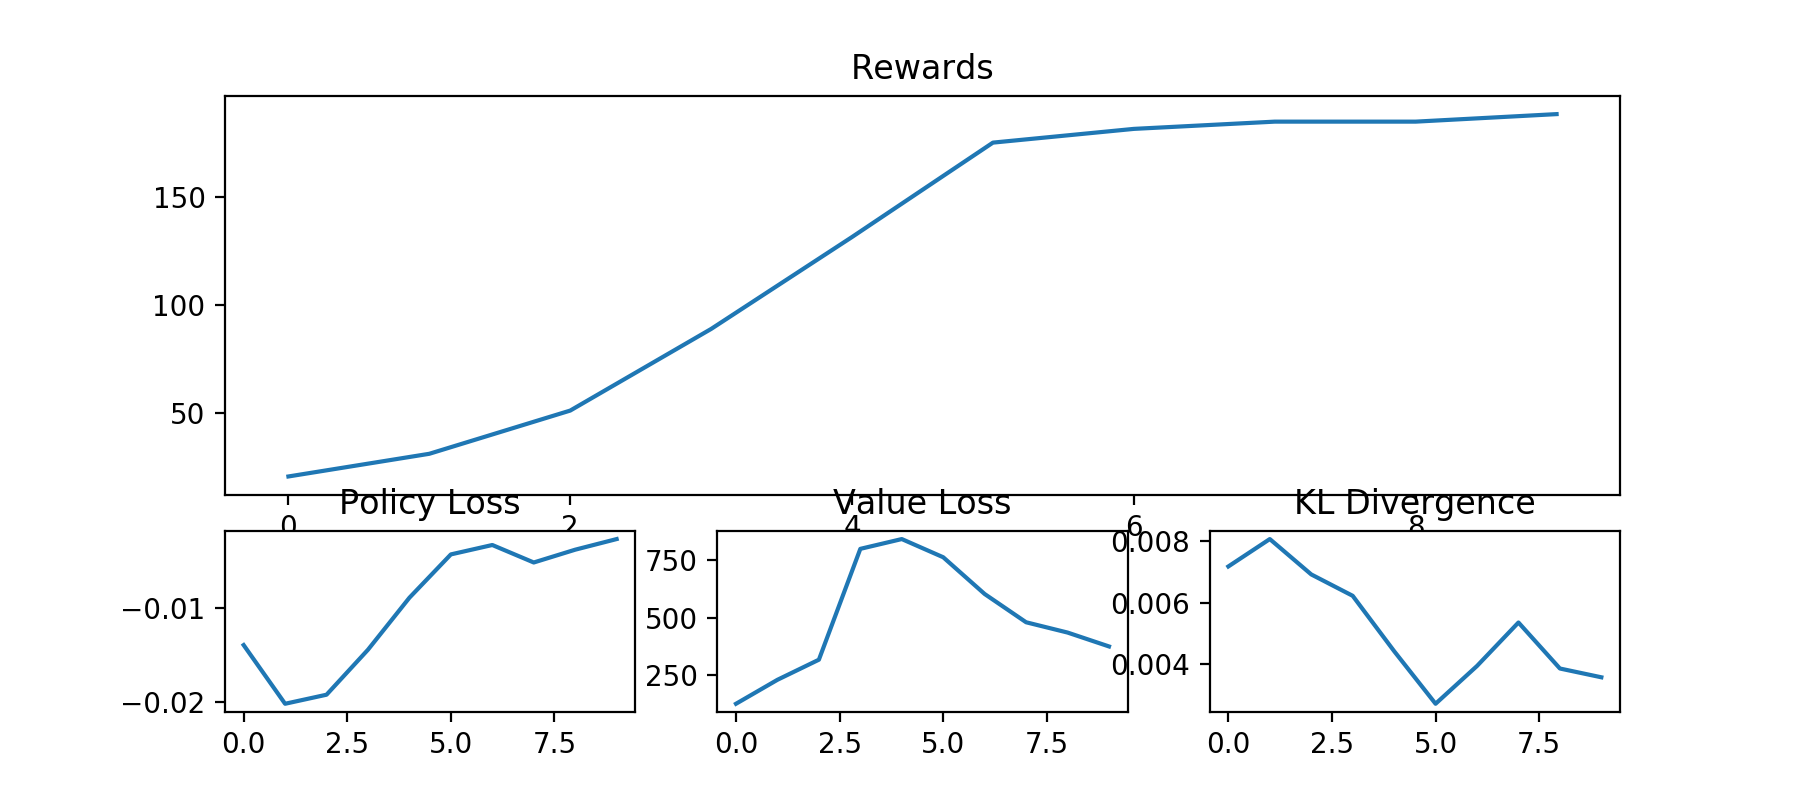

New model created successfully


Game 1 of epoch: 1, reward: 16.00
Game 2 of epoch: 1, reward: 16.00
Game 3 of epoch: 1, reward: 22.00
Game 4 of epoch: 1, reward: 24.00
Game 5 of epoch: 1, reward: 22.00
Game 6 of epoch: 1, reward: 11.00
Game 7 of epoch: 1, reward: 20.00
Game 8 of epoch: 1, reward: 44.00
Game 9 of epoch: 1, reward: 10.00
Game 10 of epoch: 1, reward: 21.00
Game 11 of epoch: 1, reward: 18.00
Game 12 of epoch: 1, reward: 16.00
Game 13 of epoch: 1, reward: 34.00
Game 14 of epoch: 1, reward: 26.00
Game 15 of epoch: 1, reward: 26.00
Game 16 of epoch: 1, reward: 22.00
Game 17 of epoch: 1, reward: 18.00
Game 18 of epoch: 1, reward: 22.00
Game 19 of epoch: 1, reward: 23.00
Game 20 of epoch: 1, reward: 25.00
Game 21 of epoch: 1, reward: 35.00
Game 22 of epoch: 1, reward: 22.00
Game 23 of epoch: 1, reward: 12.00
Game 24 of epoch: 1, reward: 11.00
Game 25 of epoch: 1, reward: 14.00
Game 26 of epoch: 1, reward: 11.00
Game 27 of epoch: 1, reward: 33.00
Game 28 of epoch: 1, reward: 12.00
Game 29 of epoch: 1, reward: 

/Users/zr/miniconda3/envs/ai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PPOModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Game 8 of epoch: 2, reward: 38.00
Game 9 of epoch: 2, reward: 42.00
Game 10 of epoch: 2, reward: 28.00
Game 11 of epoch: 2, reward: 37.00
Game 12 of epoch: 2, reward: 13.00
Game 13 of epoch: 2, reward: 11.00
Game 14 of epoch: 2, reward: 41.00
Game 15 of epoch: 2, reward: 20.00
Game 16 of epoch: 2, reward: 15.00
Game 17 of epoch: 2, reward: 22.00
Game 18 of epoch: 2, reward: 49.00
Game 19 of epoch: 2, reward: 69.00
Game 20 of epoch: 2, reward: 26.00
Game 21 of epoch: 2, reward: 29.00
Game 22 of epoch: 2, reward: 19.00
Game 23 of epoch: 2, reward: 35.00
Game 24 of epoch: 2, reward: 48.00
Game 25 of epoch: 2, reward: 28.00
Game 26 of epoch: 2, reward: 30.00
Game 27 of epoch: 2, reward: 34.00
Game 28 of epoch: 2, reward: 84.00
Game 29 of epoch: 2, reward: 10.00
Game 30 of epoch: 2, reward: 60.00
Game 31 of epoch: 2, reward: 47.00
Game 32 of epoch: 2, reward: 54.00
Game 33 of epoch: 2, reward: 23.00
Game 34 of epoch: 2, reward: 30.00
Game 35 of epoch: 2, reward: 24.00
Game 36 of epoch: 2, r

Game 42 of epoch: 4, reward: 150.00
Game 43 of epoch: 4, reward: 35.00
Game 44 of epoch: 4, reward: 47.00
Game 45 of epoch: 4, reward: 126.00
Game 46 of epoch: 4, reward: 97.00
Game 47 of epoch: 4, reward: 167.00
Game 48 of epoch: 4, reward: 124.00
Game 49 of epoch: 4, reward: 61.00
Game 50 of epoch: 4, reward: 56.00
Game 51 of epoch: 4, reward: 180.00
Game 52 of epoch: 4, reward: 66.00
Game 53 of epoch: 4, reward: 14.00
Game 54 of epoch: 4, reward: 72.00
Game 55 of epoch: 4, reward: 23.00
Game 56 of epoch: 4, reward: 139.00
Game 57 of epoch: 4, reward: 98.00
Game 58 of epoch: 4, reward: 147.00
Game 59 of epoch: 4, reward: 38.00
Game 60 of epoch: 4, reward: 26.00
Game 61 of epoch: 4, reward: 164.00
Game 62 of epoch: 4, reward: 74.00
Game 63 of epoch: 4, reward: 57.00
Game 64 of epoch: 4, reward: 99.00
Game 65 of epoch: 4, reward: 19.00
Game 66 of epoch: 4, reward: 189.00
Game 67 of epoch: 4, reward: 41.00
Game 68 of epoch: 4, reward: 54.00
Game 69 of epoch: 4, reward: 200.00
Game 70 of

Game 38 of epoch: 7, reward: 164.00
Game 39 of epoch: 7, reward: 200.00
Game 40 of epoch: 7, reward: 200.00
Game 41 of epoch: 7, reward: 168.00
Game 42 of epoch: 7, reward: 196.00
Game 43 of epoch: 7, reward: 200.00
Game 44 of epoch: 7, reward: 184.00
Game 45 of epoch: 7, reward: 200.00
Game 46 of epoch: 7, reward: 200.00
Game 47 of epoch: 7, reward: 90.00
Game 48 of epoch: 7, reward: 200.00
Game 49 of epoch: 7, reward: 200.00
Game 50 of epoch: 7, reward: 147.00
Game 51 of epoch: 7, reward: 200.00
Game 52 of epoch: 7, reward: 190.00
Game 53 of epoch: 7, reward: 54.00
Game 54 of epoch: 7, reward: 200.00
Game 55 of epoch: 7, reward: 90.00
Epoch 7, rewards: 181.82
Game 1 of epoch: 8, reward: 200.00
Game 2 of epoch: 8, reward: 172.00
Game 3 of epoch: 8, reward: 200.00
Game 4 of epoch: 8, reward: 200.00
Game 5 of epoch: 8, reward: 200.00
Game 6 of epoch: 8, reward: 185.00
Game 7 of epoch: 8, reward: 200.00
Game 8 of epoch: 8, reward: 200.00
Game 9 of epoch: 8, reward: 200.00
Game 10 of epoc

In [45]:
%matplotlib notebook
fig = plt.figure(figsize=(9, 4))

try:
    if not create_new_model:
        model = t.load('./ppo.pt')
        print('Model loaded successfully.')
    else:
        model = PPOModel(obs_dim, act_dim, buffer_kwargs=buffer_kwargs, **model_kwargs)
        print('New model created successfully')
except:
    model = PPOModel(obs_dim, act_dim, buffer_kwargs=buffer_kwargs, **model_kwargs)
    print('Model not found. Creating new.')

total_rews = []
p_bar = tnrange(epochs)
for epoch in p_bar:
    
    # Reset and prepare
    obs, rew, done = env.reset(), 0, False
    total_episode_reward, epoch_rews = 0, []
    finished_rendering_this_epoch    = False
    game_n = 0
    
    # -------- Start Trajectory -------- #
    for step in range(steps_per_epoch):
        
        if games_per_epoch is not None and game_n == games_per_epoch:
            break

        if render and not finished_rendering_this_epoch:
            env.render()
        
        # -------- Action -------- #
        obs         = t.tensor([obs], requires_grad=False).float()
        act, logp_t = model.act(obs)
        act         = [act.item()]
        logp_t      = [logp_t.item()]
        v_t         = [model.val(obs).item()]
        
        # -------- Store -------- #
        model.buf.store(obs.numpy(), act, rew, v_t, logp_t)
        obs, rew, done, _ = env.step(act[0] if categorical else act)
        
        total_episode_reward += rew

        # -------- End Game Action-------- #
        if done or (step==steps_per_epoch-1):
            obs      = t.tensor([obs], requires_grad=False).float()
            last_val = rew if done else model.val(obs).item()
            model.buf.finish_path(last_val)

            epoch_rews.append(total_episode_reward)
            p_bar.write(f'Game {game_n+1} of epoch: {epoch+1}, reward: {total_episode_reward:.2f}')
            game_n += 1
            
            # -------- Reset -------- #
            obs, rew, done       = env.reset(), 0, False
            total_episode_reward = 0
            finished_rendering_this_epoch = True

    
    # -------- Train and Log -------- #
    model.update()
    model.buf.reset()
    total_rews.append(sum(epoch_rews)/len(epoch_rews))
    p_bar.write(f'Epoch {epoch+1}, rewards: {(sum(epoch_rews)/len(epoch_rews)):.2f}')
    
    # Save model
    t.save(model, './ppo.pt')
    
    ax_rw = plt.subplot2grid((3, 3), (0, 0), rowspan=2,colspan=3)
    ax_rw.set_title('Rewards')
    ax_rw.plot(total_rews)

    ax_pl = plt.subplot2grid((3, 3), (2, 0))
    ax_pl.set_title('Policy Loss')
    ax_pl.plot(model.p_loss_hist)

    ax_vl = plt.subplot2grid((3, 3), (2, 1))
    ax_vl.set_title('Value Loss')
    ax_vl.plot(model.v_loss_hist)
    
    ax_kl = plt.subplot2grid((3, 3), (2, 2))
    ax_kl.set_title('KL Divergence')
    ax_kl.plot(model.kl_hist)

    fig.canvas.draw()

### Model Graphs

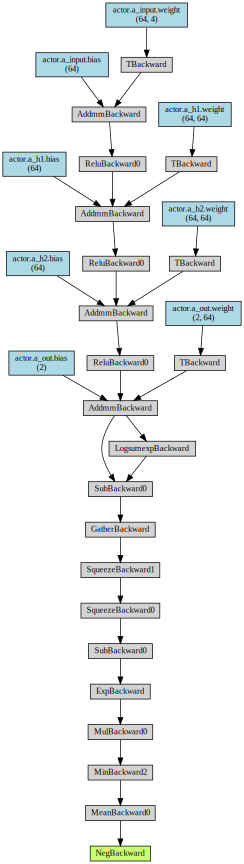

In [41]:
# Actor Model
buf = {k:t.from_numpy(v).float() for k,v in zip(['obs', 'acts', 'advs', 'rets', 'logps'], model.buf.get())}
    
logits      = model.actor(buf['obs'])
policy      = t.distributions.Categorical(logits=logits)
logps       = policy.log_prob(buf['acts']).squeeze()
ratio       = t.exp(logps - buf['logps'])
clipped_adv = t.where(buf['advs'] > 0, (1 + model.clip_ratio) * buf['advs'], (1 - model.clip_ratio) * buf['advs'])
pi_loss     = -t.mean(t.min(ratio * buf['advs'], clipped_adv))
            
make_dot(pi_loss, params=dict(model.named_parameters()))

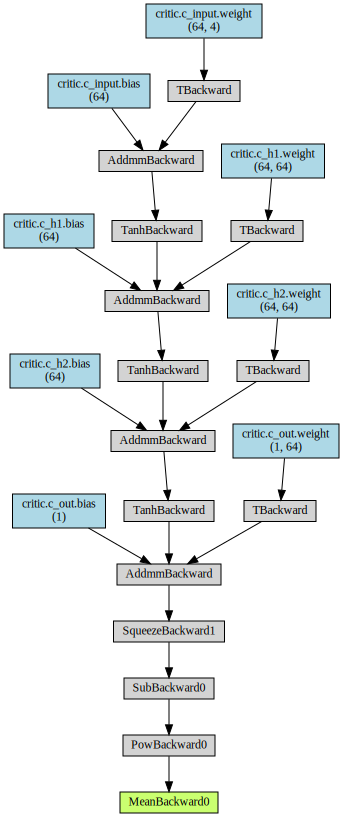

In [38]:
# Critic Model
v      = model.val(t.tensor([[0.,0.,0.,0.]]))
v_loss = t.mean((buf['rets'] - v)** 2)
make_dot(v_loss, params=dict(model.named_parameters()))

## Scratch paper